In [1]:
from matplotlib.ticker import MultipleLocator
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
stock_list = pd.read_csv('data/selected_stock_list.csv')['Code']
stock_dict = {}
for stock in stock_list:
    stock_dict[stock] = pd.read_csv('data/full/{}_full.csv'.format(stock), index_col=0)
date_list = stock_dict[stock_list.iloc[0]].index[1:]

In [3]:
price_dict = {}
for stock in stock_list:
    stock_df = stock_dict[stock]
    price_dict[stock] = stock_df['Adj Close'].pct_change()
    
    stock_dict[stock]['Accumulated Return'] = np.cumprod(1 + price_dict[stock]) - 1
    stock_dict[stock]['Return'] = price_dict[stock]

In [4]:
last_observation_dict = {}
last_price_dict = {}
for date in date_list:
    X = pd.DataFrame(columns = stock_dict[stock_list.iloc[0]].columns)
    y = pd.DataFrame(columns = [price_dict[stock_list.iloc[0]].name])
    for stock in stock_list:
        X.loc[stock] = stock_dict[stock].loc[date]
        y.loc[stock] = price_dict[stock].loc[date]
    last_observation_dict[date] = X
    last_price_dict[date] = y

Different metrics can be tested (to do)

In [5]:
def get_max_distance(X, alpha):
    pairwise_dist = pairwise_distances(X, metric='l1')
    nearest_distances = np.sort(pairwise_dist, axis=1)[:, 1]
    return np.quantile(nearest_distances, alpha)

In [6]:
# grid = {'alpha': np.linspace(start=0.01, stop=0.5, num=50)}
alpha = 0.15

In [7]:
return_list = []
for i, date in enumerate(date_list[: -1]):
    X = last_observation_dict[date]
    max_distance = get_max_distance(X, alpha)
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=max_distance, linkage='average', metric='l1')
    label = pd.Series(clustering.fit_predict(X), index=stock_list)
    long_list = []
    short_list = []
    for j in range(label.nunique()):
        selected_stock_list = label[label.eq(j)].index
        if len(selected_stock_list) > 1:
            long_list += list(last_price_dict[date].loc[selected_stock_list].sort_values(by='Adj Close').iloc[: len(selected_stock_list) // 2].index)
            short_list += list(last_price_dict[date].loc[selected_stock_list].sort_values(by='Adj Close').iloc[-(len(selected_stock_list) // 2):].index)
    return_list.append(last_price_dict[date_list[i + 1]].loc[long_list].mean().iloc[0] - last_price_dict[date_list[i + 1]].loc[short_list].mean().iloc[0])
value_list = np.cumprod(1 + np.array(return_list))

In [8]:
SPX = yf.download('^SPX', start='2013-06-01', end='2023-12-31', period='1d')['Adj Close'].resample('ME').last()

[*********************100%%**********************]  1 of 1 completed


Text(0.5, 0, 'Date')

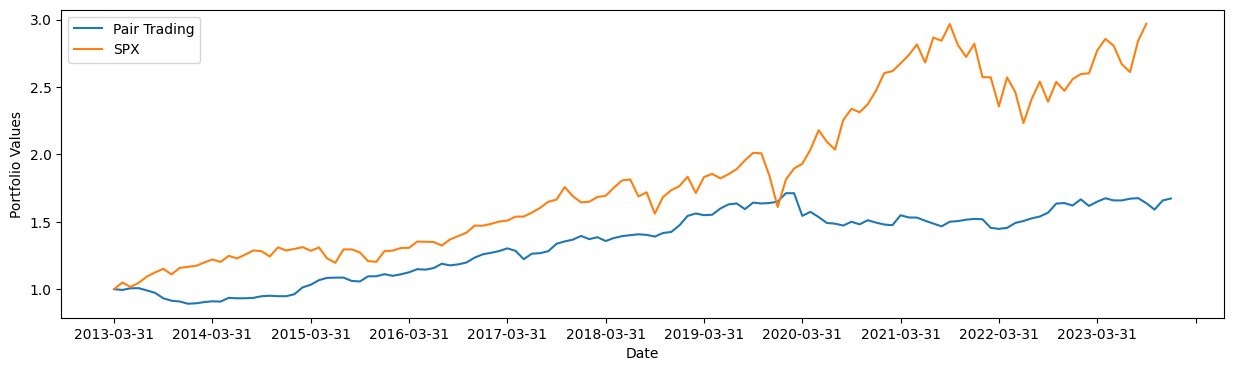

In [9]:
fig, ax = plt.subplots(figsize=(15, 4))
plt.plot(date_list, [1] + list(value_list), label='Pair Trading')
plt.plot(SPX.values / SPX.iloc[0], label='SPX')
ax.xaxis.set_major_locator(MultipleLocator(12))
plt.legend()
plt.ylabel("Portfolio Values")
plt.xlabel("Date")